In [1]:
'''
The script can load and pre-process the CESM-LENS precipitation data into monthly data combining 40 ensembles
for clustering analysis; the final output will be labelled targets for each winter, cluster centorid plots

'''

In [ ]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle

In [2]:
# load raw and return monthly average and regional longitude, latitude in EU
def data_load_cesm(fn, start, end, ratetype):
    ds_prec_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_prec_xr = ds_prec_xr.sel(time=slice(start, end)).load()
    # convert 0-360 to -180-180
    ds_prec_xr = ds_prec_xr.assign_coords(lon=(((ds_prec_xr.lon + 180) % 360) - 180))
    
    reg_lon_xr = ds_prec_xr['lon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_prec_xr['lat'] # from 25.375N to 75.375N
    prec_temp_xr = ds_prec_xr[ratetype]
    
    # combine for merge two dataset with same coordinate (east and west sphere)
    prec_xr1 = prec_temp_xr[:,133:174,-10:].combine_first(prec_temp_xr[:,133:174,:30])
    prec_xr = prec_xr1*1000*86400 # from m/s to mm/day
    
    return prec_xr, reg_lat_xr, reg_lon_xr

In [3]:
# calculate normalized anomalies -- substracting climatology
# climatology based on 1976 to 2005 -- refered to ECMWF
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()
    lons_xr = dataset['lon'] # from -12W to 36E
    lats_xr = dataset['lat'] # from 35N to 73N
    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized

    return prcp_anom

In [4]:
# extract and group each season data
def seasonal_data(anom, season):
    month_length = anom.time.dt.days_in_month # way to calculate the days in each month
    season_res = ((anom * month_length).resample(time='QS-DEC').sum(skipna=False) / 
          month_length.resample(time='QS-DEC').sum(skipna=False))
    # Using 'QS-DEC' frequency will split the data into consecutive three-month periods, anchored at December 1st.
    season_group = season_res.groupby("time.season").groups # group into seasons, use groups to read each group
    season_index = season_group[season]
    season_anom = season_res[season_index,:,:]

    return season_anom

In [5]:

def visualize_cluster(data, reg_lon_xr, reg_lat_xr, title1, title2):
    #data[~np.isfinite(data)] = 0
    #data = data.fillna(0)
    #data = data.where(data < 2, other=0)
    data = xr.where((data > 2),2,data) # rather 0 but a maximum value here
    matplotlib.rcParams['xtick.labelsize'] = 15
    matplotlib.rcParams['ytick.labelsize'] = 15
    matplotlib.rcParams['axes.labelsize'] = 15
    fig = plt.figure(figsize=(11,8.5), dpi = 300)
    fig = plt.gcf()
    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())

    # Add cyclic point to data
    #data=mean_anom_djf_cluster1
    data, lats = add_cyclic_point(data, coord=reg_lat_xr)

    # Make a filled contour plot
    cs=ax.contourf(lats, reg_lon_xr, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both') # (lat, lon)

    # Add coastlines
    ax.coastlines()

    # Define the xticks for longitude
    ax.set_xticks(np.arange(-12,40,5), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    plt.title(title2, fontsize = 18)
    ax.set_yticks(np.arange(33,75,5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.tight_layout()
    # Add colorbar
    cbar = plt.colorbar(cs)
    
    fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster\prcp_eobs_season\%s.png' % title1)

In [6]:
# Read all files in the folder
import os
path_precl = r'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/CESM1/PRECL'
filelist_precl = os.listdir(path_precl)
path_precc = r'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/CESM1/PRECC'
filelist_precc = os.listdir(path_precc)

pathlist_precl = []
for i in range(len(filelist_precl)):
    temp = path_precl + '/' + filelist_precl[i]
    pathlist_precl.append(temp)
    
pathlist_precc = []
for i in range(len(filelist_precc)):
    temp = path_precc + '/' + filelist_precc[i]
    pathlist_precc.append(temp)

In [16]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

season = 'DJF'

fn1 = pathlist_precc[0]
precc_xr, reg_lat_xr, reg_lon_xr = data_load_cesm(fn1, '192002', '200601', 'PRECC')

temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
temp_xr = temp_xr.sel(time=slice('1920', '2005')).load() # be aware of the time here!!!

fn2 = pathlist_precl[0]
precl_xr, reg_lat_xr, reg_lon_xr = data_load_cesm(fn2, '192002', '200601', 'PRECL')

# total precipitation -- prect mm/day
prect_xr = precl_xr + precc_xr

data = prect_xr.values
time = temp_xr.time
lon = prect_xr.lon
lat = prect_xr.lat
prect_xr_new = xr.DataArray(data, coords=[time, lat, lon], dims=['time', 'lat', 'lon'])

# calculate anomaly
prect_anom = nor_anom(prect_xr_new)

# detrend the time series at each grid point
prect_danom = detrend_dim(prect_anom, 'time', deg=1)

# extract and group each season data
anom_ensemble = seasonal_data(prect_danom, season)
anom_original = seasonal_data(prect_danom, season)

In [17]:
### concatenate 40 ensembles together ###
for i in range(1,len(filelist_precl)):

    fn1 = pathlist_precc[i]
    precc_xr, reg_lat_xr, reg_lon_xr = data_load_cesm(fn1, '192002', '200601', 'PRECC')

    fn2 = pathlist_precl[i]
    precl_xr, reg_lat_xr, reg_lon_xr = data_load_cesm(fn2, '192002', '200601', 'PRECL')

    # calculate anomaly
    prect_anom = nor_anom(precl_xr + precc_xr)
    
    data = prect_anom.values
    time = temp_xr.time
    lon = prect_anom.lon
    lat = prect_anom.lat
    prect_anom_new = xr.DataArray(data, coords=[time, lat, lon], dims=['time', 'lat', 'lon'])
    
    # detrend the time seires
    prect_danom = detrend_dim(prect_anom_new, 'time', deg=1)

    # extract and group each season data
    anom_gb_temp = seasonal_data(prect_danom, season)
    
    if np.array_equal(anom_ensemble.lat, anom_gb_temp.lat) == False: # check if two array is exactly the same
        data = anom_gb_temp.values
        time = anom_gb_temp.time
        lon = anom_original.lon
        lat = anom_original.lat
        anom_gb_temp = xr.DataArray(data, coords=[time, lat, lon], dims=['time', 'lat', 'lon'])

    anom_ensemble = xr.concat([anom_ensemble,anom_gb_temp], dim='time')

In [18]:
### save and load as netcdf ###
anom_ensemble.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\ensemble_data\prcp_detrend_ensemble_DJF.nc')

In [7]:
### load data ###
anom_ensemble = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\ensemble_data\prcp_detrend_ensemble_DJF.nc')
anom_ensemble = anom_ensemble.__xarray_dataarray_variable__

In [11]:
# before clustering, all ensemble should be stacked
# data pre-process before clustering
np_anom_ensemble_reshape = np.array(anom_ensemble).reshape(len(anom_ensemble.time), 
                                         len(anom_ensemble.lat)*len(anom_ensemble.lon))
# infinite to zero
np_anom_ensemble_reshape[~np.isfinite(np_anom_ensemble_reshape)] = 0

In [13]:
### apply hierarchy clustering on 40 ensembles data ###
k = 3
season = 'DJF'
scaler = StandardScaler()
scaled_features = scaler.fit_transform(np_anom_ensemble_reshape)

hc_cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
hc_index = hc_cluster.fit_predict(scaled_features)
cluster_index = hc_index

### visualize cluster result by dendogram ###

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(scaled_features, method='ward'))

In [15]:
# calculate each cluster and cluster mean (for visualization)

cluster_dic = {}
cluster_mean = []
cluster_xr = {} 
for i in range(0, k): # k start from 0
    cluster = list(np.array(np.where(cluster_index == i)).reshape(np.array(np.where(cluster_index == i)).shape[1],))
    anom_ensemble_cluster = anom_ensemble[cluster,:,:]
    cluster_xr['%s' % i] = anom_ensemble_cluster
    
    # data pre-process
    np_anom_ensemble_cluster_reshape = np.array(anom_ensemble_cluster).reshape(len(anom_ensemble_cluster.time), 
                                             len(anom_ensemble_cluster.lat)*len(anom_ensemble_cluster.lon))
    # infinite to zero
    np_anom_ensemble_cluster_reshape[~np.isfinite(np_anom_ensemble_cluster_reshape)] = 0
    cluster_dic['%s' % i] = np_anom_ensemble_cluster_reshape # store cluster in the dict
    # calculate the centroid of each cluster
    cluster_mean.append(np_anom_ensemble_cluster_reshape.mean(axis = 0))

In [41]:
### labeling the data (target) for each winter precipitation based on cluster index ###
data = {
  "Time": pd.Series(anom_ensemble.time),
  "Target": cluster_index+1
}

df = pd.DataFrame((cluster_index+1),index = pd.Series(anom_ensemble.time),columns=['Target'],dtype=float)
df = pd.DataFrame(data)
df.to_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster_data\input_output.csv')

In [13]:
import pickle
df3 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster_data\DJF_k4.txt'
          ,'rb')
### load cluster ###
cluster_xr = pickle.load(df3)
df3.close()

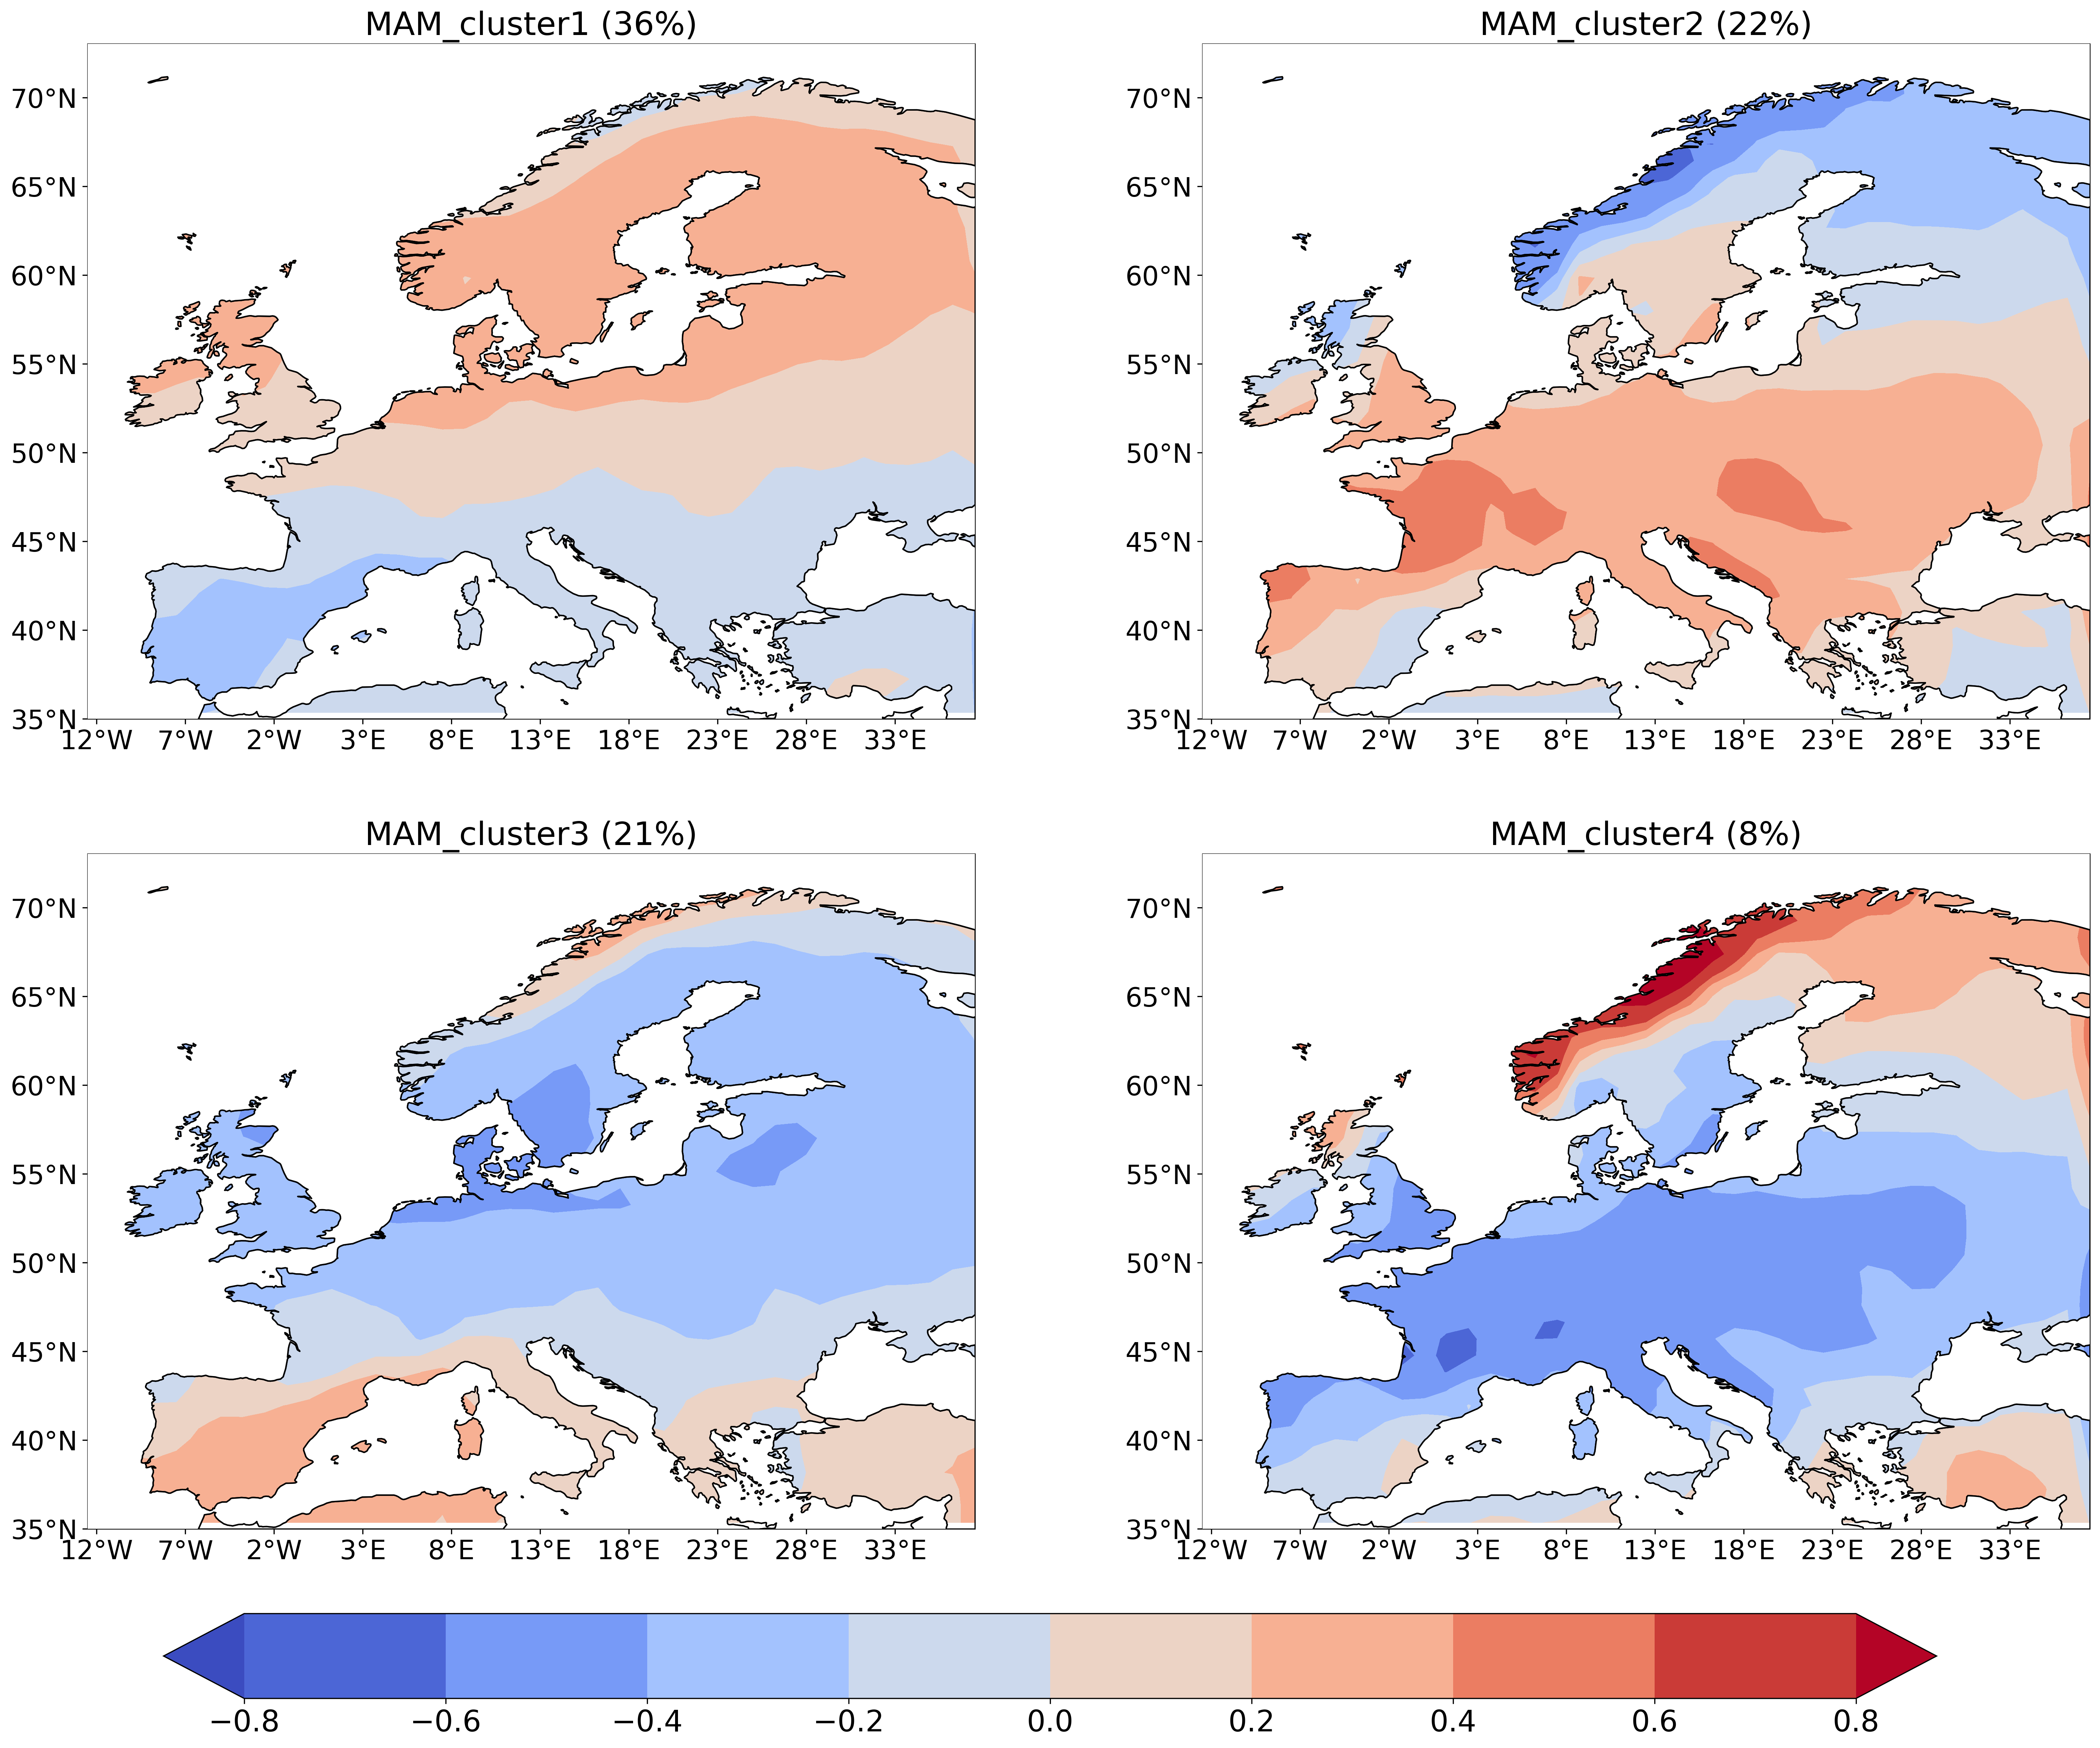

In [51]:
# plot cluster map -- DJF and MAM
# visualize filterd dataset (cluster centroid)

vmin = -0.8
vmax = 0.8

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18

fig, axs = plt.subplots(2,2, figsize=(22, 20), subplot_kw=dict(projection=ccrs.PlateCarree()),dpi =300)

fig = plt.gcf()

title1 = '%s_cluster' % (season)

for ax, k in zip(axs.ravel(), range(4)):
    data = cluster_xr['%s' % k].mean('time')
    
    ratio = int((len(cluster_xr['%s' % k])/3840)*100)
    title2 = '%s_cluster%s (%s%%)' % (season, k+1, ratio)
    # time
    data = xr.where((data > 2),2,data) # rather 0 but a maximum value here

    # Add cyclic point to data
    data, lons = add_cyclic_point(data, coord=lon)

    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()
    # mask the ocean part with white color
    ax.add_feature(cart.feature.OCEAN, facecolor = 'white', zorder=200, edgecolor='k')
    cs=ax.contourf(lons, lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',levels = np.linspace(-0.8,0.8,9),
                   extend='both') # (lat, lon)

    # Define the xticks for longitude
    ax.set_xticks(np.arange(-12,37,5), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    #plt.title(title2, fontsize = 18)
    ax.set_title(title2, fontsize = 22)
    ax.set_yticks(np.arange(35,73,5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    
fig.tight_layout()
fig.subplots_adjust(bottom = 0.2, top = 0.9, hspace =0.2, wspace=.005)    

# Add colorbar
bar_cax = plt.axes([0.12, 0.12, 0.76,0.04])
#plt.colorbar(cax=cax)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 20)

fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster\cesm\%s_k4_new.png' 
            % title1)


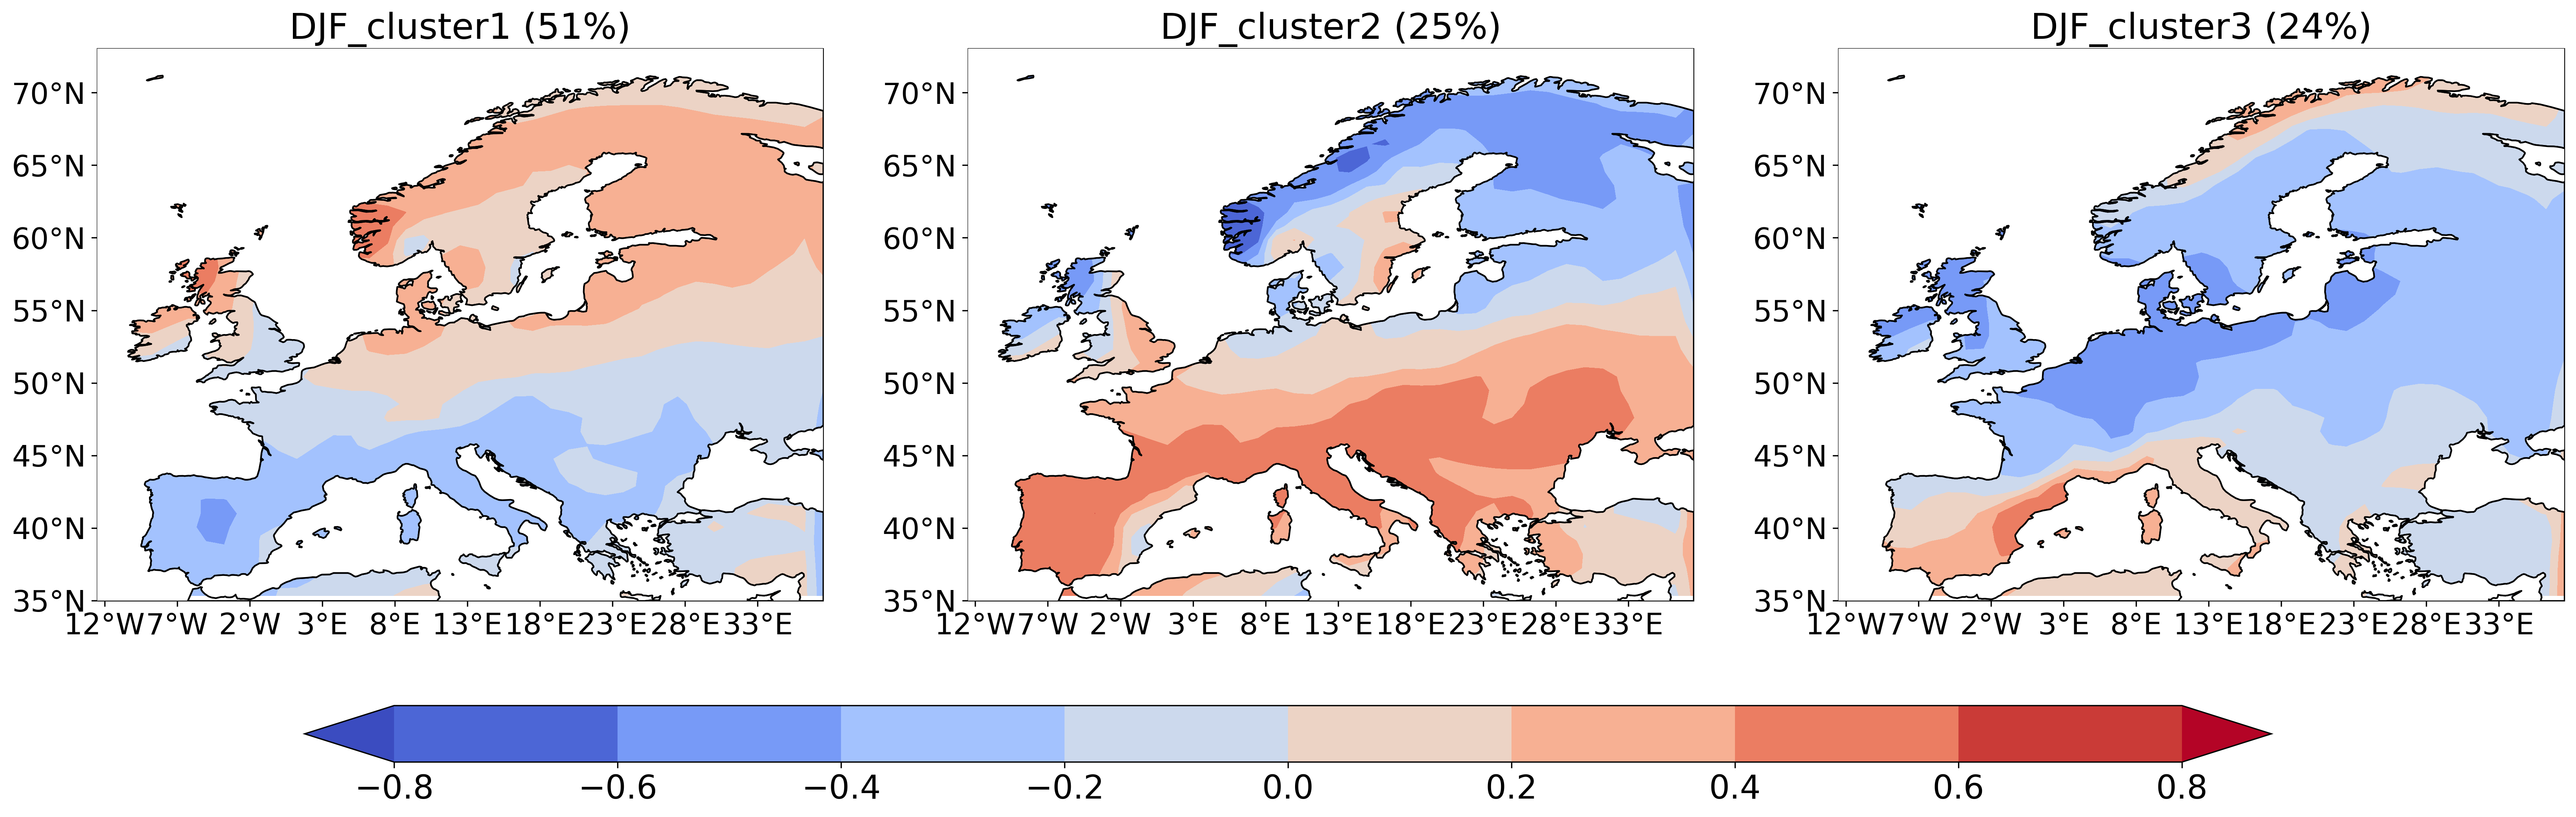

In [62]:
# k = 3 

# plot cluster map
# visualize filterd dataset (cluster centroid)
#(data, reg_lon_xr, reg_lat_xr, title1, title2)

vmin = -0.8
vmax = 0.8

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18

fig, axs = plt.subplots(1,3, figsize=(22, 12), subplot_kw=dict(projection=ccrs.PlateCarree()),dpi =300)

fig = plt.gcf()

title1 = '%s_cluster' % (season)

for ax, k in zip(axs.ravel(), range(3)):

    data = cluster_xr['%s' % k].mean('time')
    
    ratio = int((len(cluster_xr['%s' % k])/3440)*100) # for DJF 3840, others 3440
    title2 = '%s_cluster%s (%s%%)' % (season, k+1, ratio)
    # time
    data = xr.where((data > 2),2,data) # rather 0 but a maximum value here
    # Add cyclic point to data
    data, lons = add_cyclic_point(data, coord=lon)

    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()
    # mask the ocean part with white color
    ax.add_feature(cart.feature.OCEAN, facecolor = 'white', zorder=200, edgecolor='k')
    cs=ax.contourf(lons, lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',levels = np.linspace(-0.8,0.8,9),
                   extend='both') # (lat, lon)
    
    # Define the xticks for longitude
    ax.set_xticks(np.arange(-12,37,5), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    ax.set_title(title2, fontsize = 22)
    ax.set_yticks(np.arange(35,73,5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    
fig.tight_layout()
fig.subplots_adjust(bottom = 0.12, top = 0.9, hspace =0.2, wspace=.2)      

# Add colorbar
bar_cax = plt.axes([0.12, 0.2, 0.76,0.04])
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 20)

fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster\cesm\%s_k3_new.png' % title1)
